<a href="https://colab.research.google.com/github/GenSKNeo/Decision-Intelligence-Dashboard/blob/main/m17w19_lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Task 3: Collaborative Filtering Implementation

In [ ]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

print("Loading and preparing real dataset...")

# Define the file path
file_path_movies = '/content/drive/MyDrive/Data2025/movies.csv'
file_path_ratings = '/content/drive/MyDrive/Data2025/ratings.csv'

# Load the CSV file into a DataFrame
movies = pd.read_csv(file_path_movies)
ratings = pd.read_csv(file_path_ratings)

# Load the actual datasets
# ratings = pd.read_csv('ratings.csv')
# movies = pd.read_csv('movies.csv')

print(f"Ratings dataset: {len(ratings)} ratings")
print(f"Movies dataset: {len(movies)} movies")
print("\nFirst few rows of ratings:")
print(ratings.head())
print("\nFirst few rows of movies:")
print(movies.head())

Loading and preparing real dataset...
Ratings dataset: 100836 ratings
Movies dataset: 9742 movies

First few rows of ratings:
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931

First few rows of movies:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


In [ ]:
# 3a) Build user-item matrix (utility matrix)
print("\n" + "="*50)
print("TASK 3a: Building User-Item Matrix")
print("="*50)

def build_user_item_matrix(ratings_df):
    """
    Build a user-item matrix where rows are users and columns are movies
    """
    # Create pivot table with users as rows and movies as columns
    user_item_matrix = ratings_df.pivot_table(
        index='userId',
        columns='movieId',
        values='rating',
        fill_value=0  # Fill missing ratings with 0
    )
    return user_item_matrix

# Build the matrix
user_item_matrix = build_user_item_matrix(ratings)
print("User-Item Matrix Shape:", user_item_matrix.shape)
print("First 5 rows and 5 columns of the matrix:")
print(user_item_matrix.iloc[:5, :5])

# Display movie titles for better understanding
print("\nMovie titles for first 5 columns:")
for i, movie_id in enumerate(user_item_matrix.columns[:5]):
    movie_title = movies[movies['movieId'] == movie_id]['title'].values
    if len(movie_title) > 0:
        print(f"Movie {movie_id}: {movie_title[0]}")


TASK 3a: Building User-Item Matrix
User-Item Matrix Shape: (610, 9724)
First 5 rows and 5 columns of the matrix:
movieId    1    2    3    4    5
userId                          
1        4.0  0.0  4.0  0.0  0.0
2        0.0  0.0  0.0  0.0  0.0
3        0.0  0.0  0.0  0.0  0.0
4        0.0  0.0  0.0  0.0  0.0
5        4.0  0.0  0.0  0.0  0.0

Movie titles for first 5 columns:
Movie 1: Toy Story (1995)
Movie 2: Jumanji (1995)
Movie 3: Grumpier Old Men (1995)
Movie 4: Waiting to Exhale (1995)
Movie 5: Father of the Bride Part II (1995)


In [ ]:
# 3b) Calculate sparsity of the user-item matrix
print("\n" + "="*50)
print("TASK 3b: Calculating Matrix Sparsity")
print("="*50)

def calculate_sparsity(matrix):
    """
    Calculate the sparsity percentage of a matrix
    """
    total_elements = matrix.shape[0] * matrix.shape[1]
    zero_elements = (matrix == 0).sum().sum()  # Count zeros in entire matrix
    sparsity = (zero_elements / total_elements) * 100
    return sparsity

sparsity = calculate_sparsity(user_item_matrix)
print(f"Sparsity of the user-item matrix: {sparsity:.2f}%")
print(f"Matrix dimensions: {user_item_matrix.shape[0]} users × {user_item_matrix.shape[1]} movies")
print(f"Total elements: {user_item_matrix.shape[0] * user_item_matrix.shape[1]:,}")
print(f"Non-zero ratings: {(user_item_matrix != 0).sum().sum():,}")

# Interpretation
print("\nInterpretation:")
if sparsity > 95:
    print("The matrix is highly sparse (>95%), which is typical for real-world recommendation systems.")
    print("This sparsity can challenge traditional collaborative filtering methods.")
else:
    print("The matrix has moderate sparsity, which is manageable for recommendation algorithms.")


TASK 3b: Calculating Matrix Sparsity
Sparsity of the user-item matrix: 98.30%
Matrix dimensions: 610 users × 9724 movies
Total elements: 5,931,640
Non-zero ratings: 100,836

Interpretation:
The matrix is highly sparse (>95%), which is typical for real-world recommendation systems.
This sparsity can challenge traditional collaborative filtering methods.


In [ ]:
# 3c) K-Nearest Neighbors for recommendations
print("\n" + "="*50)
print("TASK 3c: K-Nearest Neighbors Recommendations")
print("="*50)

class KNNRecommender:
    def __init__(self, k=5, metric='cosine'):
        self.k = k
        self.metric = metric
        self.model = None
        self.user_item_matrix = None
        self.movies_df = None

    def fit(self, user_item_matrix, movies_df):
        """Fit the KNN model on the user-item matrix"""
        self.user_item_matrix = user_item_matrix
        self.movies_df = movies_df

        # Convert to sparse matrix for efficiency
        sparse_matrix = csr_matrix(user_item_matrix.values)

        # Initialize and fit KNN model
        self.model = NearestNeighbors(n_neighbors=self.k, metric=self.metric, algorithm='brute')
        self.model.fit(sparse_matrix)
        return self

    def recommend(self, user_id, top_n=5):
        """Recommend top N movies for a given user"""
        if user_id not in self.user_item_matrix.index:
            return f"User {user_id} not found in the dataset"

        user_idx = list(self.user_item_matrix.index).index(user_id)
        user_ratings = self.user_item_matrix.iloc[user_idx]

        # Find k nearest neighbors
        user_vector = csr_matrix(user_ratings.values).reshape(1, -1)
        distances, indices = self.model.kneighbors(user_vector)

        # Get neighbors' ratings
        neighbor_indices = indices.flatten()[1:]  # Exclude the user itself
        neighbor_ratings = self.user_item_matrix.iloc[neighbor_indices]

        # Calculate average ratings from neighbors
        avg_ratings = neighbor_ratings.mean(axis=0)

        # Filter out movies already rated by the user
        user_rated_movies = user_ratings[user_ratings > 0].index
        recommendations = avg_ratings.drop(user_rated_movies, errors='ignore')

        # Get top N recommendations
        top_recommendations = recommendations.nlargest(top_n)

        # Add movie titles to recommendations
        recommendations_with_titles = []
        for movie_id, predicted_rating in top_recommendations.items():
            movie_title = self.movies_df[self.movies_df['movieId'] == movie_id]['title'].values
            if len(movie_title) > 0:
                recommendations_with_titles.append({
                    'movieId': movie_id,
                    'title': movie_title[0],
                    'predicted_rating': predicted_rating
                })
            else:
                recommendations_with_titles.append({
                    'movieId': movie_id,
                    'title': f"Movie {movie_id}",
                    'predicted_rating': predicted_rating
                })

        return recommendations_with_titles

# Initialize and fit the recommender
knn_recommender = KNNRecommender(k=5)
knn_recommender.fit(user_item_matrix, movies)

# Test recommendation for a sample user
sample_user = user_item_matrix.index[0]  # First user in the dataset
recommendations = knn_recommender.recommend(sample_user, top_n=5)

print(f"Top 5 movie recommendations for user {sample_user}:")
for i, rec in enumerate(recommendations, 1):
    print(f"{i}. {rec['title']} (predicted rating: {rec['predicted_rating']:.2f})")

# Show what movies this user has already rated highly
print(f"\nMovies user {sample_user} has already rated highly:")
user_ratings = user_item_matrix.loc[sample_user]
highly_rated = user_ratings[user_ratings > 3.5]
for movie_id, rating in highly_rated.items():
    movie_title = movies[movies['movieId'] == movie_id]['title'].values
    if len(movie_title) > 0:
        print(f"- {movie_title[0]} (rating: {rating})")


TASK 3c: K-Nearest Neighbors Recommendations
Top 5 movie recommendations for user 1:
1. Aliens (1986) (predicted rating: 4.75)
2. Hunt for Red October, The (1990) (predicted rating: 4.25)
3. Terminator 2: Judgment Day (1991) (predicted rating: 4.00)
4. 2001: A Space Odyssey (1968) (predicted rating: 4.00)
5. Die Hard (1988) (predicted rating: 4.00)

Movies user 1 has already rated highly:
- Toy Story (1995) (rating: 4.0)
- Grumpier Old Men (1995) (rating: 4.0)
- Heat (1995) (rating: 4.0)
- Seven (a.k.a. Se7en) (1995) (rating: 5.0)
- Usual Suspects, The (1995) (rating: 5.0)
- Bottle Rocket (1996) (rating: 5.0)
- Braveheart (1995) (rating: 4.0)
- Rob Roy (1995) (rating: 5.0)
- Canadian Bacon (1995) (rating: 5.0)
- Desperado (1995) (rating: 5.0)
- Billy Madison (1995) (rating: 5.0)
- Dumb & Dumber (Dumb and Dumber) (1994) (rating: 5.0)
- Ed Wood (1994) (rating: 4.0)
- Star Wars: Episode IV - A New Hope (1977) (rating: 5.0)
- Tommy Boy (1995) (rating: 5.0)
- Clear and Present Danger (1994

In [ ]:
# 3d) Handling Cold-Start Problem for New Users
print("\n" + "="*50)
print("TASK 3d: Handling Cold-Start Problem")
print("="*50)

class ColdStartRecommender:
    def __init__(self):
        self.item_similarity = None
        self.user_item_matrix = None
        self.movies_df = None

    def fit(self, user_item_matrix, movies_df):
        """Precompute item-item similarity matrix"""
        self.user_item_matrix = user_item_matrix
        self.movies_df = movies_df

        # Calculate item-item cosine similarity
        self.item_similarity = cosine_similarity(user_item_matrix.T)
        self.item_similarity_df = pd.DataFrame(
            self.item_similarity,
            index=user_item_matrix.columns,
            columns=user_item_matrix.columns
        )
        return self

    def recommend_for_new_user(self, rated_movies, top_n=5):
        """
        Recommend movies for new users based on items they've rated
        rated_movies: dict {movie_id: rating}
        """
        if not rated_movies:
            # Fallback: return most popular movies
            movie_popularity = (self.user_item_matrix > 0).sum(axis=0)
            popular_movies = movie_popularity.nlargest(top_n)

            # Add titles to popular movies
            recommendations_with_titles = []
            for movie_id, popularity in popular_movies.items():
                movie_title = self.movies_df[self.movies_df['movieId'] == movie_id]['title'].values
                if len(movie_title) > 0:
                    recommendations_with_titles.append({
                        'movieId': movie_id,
                        'title': movie_title[0],
                        'popularity': popularity
                    })
            return recommendations_with_titles

        recommendations = {}

        for movie_id, rating in rated_movies.items():
            if movie_id not in self.item_similarity_df.index:
                continue

            # Get similar movies
            similar_movies = self.item_similarity_df[movie_id].sort_values(ascending=False)

            # Weight by user's rating and similarity
            for similar_movie, similarity in similar_movies.items():
                if similar_movie not in rated_movies:  # Skip already rated
                    if similar_movie not in recommendations:
                        recommendations[similar_movie] = 0
                    recommendations[similar_movie] += rating * similarity

        # Sort by recommendation score and return top N
        sorted_recommendations = sorted(recommendations.items(), key=lambda x: x[1], reverse=True)

        # Add titles to recommendations
        recommendations_with_titles = []
        for movie_id, score in sorted_recommendations[:top_n]:
            movie_title = self.movies_df[self.movies_df['movieId'] == movie_id]['title'].values
            if len(movie_title) > 0:
                recommendations_with_titles.append({
                    'movieId': movie_id,
                    'title': movie_title[0],
                    'recommendation_score': score
                })

        return recommendations_with_titles

# Initialize cold-start recommender
cold_start_recommender = ColdStartRecommender()
cold_start_recommender.fit(user_item_matrix, movies)

# Test with a new user who has rated a few movies
print("Testing cold-start with a new user who rated some movies:")
new_user_ratings = {
    1: 5,   # Toy Story
    260: 4, # Star Wars
    296: 5  # Pulp Fiction
}

cold_start_recommendations = cold_start_recommender.recommend_for_new_user(new_user_ratings, top_n=5)

print("User's initial ratings:")
for movie_id, rating in new_user_ratings.items():
    movie_title = movies[movies['movieId'] == movie_id]['title'].values
    if len(movie_title) > 0:
        print(f"- {movie_title[0]} (rating: {rating})")

print("\nRecommended movies based on item similarity:")
for i, rec in enumerate(cold_start_recommendations, 1):
    print(f"{i}. {rec['title']} (score: {rec['recommendation_score']:.2f})")

# Test with completely new user (no ratings)
print("\nTesting with completely new user (no ratings):")
fallback_recommendations = cold_start_recommender.recommend_for_new_user({}, top_n=5)
print("Fallback recommendations (most popular movies):")
for i, rec in enumerate(fallback_recommendations, 1):
    print(f"{i}. {rec['title']} (rated by {int(rec['popularity'])} users)")


TASK 3d: Handling Cold-Start Problem
Testing cold-start with a new user who rated some movies:
User's initial ratings:
- Toy Story (1995) (rating: 5)
- Star Wars: Episode IV - A New Hope (1977) (rating: 4)
- Pulp Fiction (1994) (rating: 5)

Recommended movies based on item similarity:
1. Star Wars: Episode V - The Empire Strikes Back (1980) (score: 8.65)
2. Star Wars: Episode VI - Return of the Jedi (1983) (score: 8.39)
3. Forrest Gump (1994) (score: 8.32)
4. Silence of the Lambs, The (1991) (score: 8.19)
5. Shawshank Redemption, The (1994) (score: 8.13)

Testing with completely new user (no ratings):
Fallback recommendations (most popular movies):
1. Forrest Gump (1994) (rated by 329 users)
2. Shawshank Redemption, The (1994) (rated by 317 users)
3. Pulp Fiction (1994) (rated by 307 users)
4. Silence of the Lambs, The (1991) (rated by 279 users)
5. Matrix, The (1999) (rated by 278 users)


In [ ]:
# Task 4: Evaluation of Recommender System
print("\n" + "="*50)
print("TASK 4: Recommender System Evaluation")
print("="*50)

# 4a) Implement evaluation metrics
print("\n4a) Implementing Evaluation Metrics")

class RecommenderEvaluator:
    def __init__(self, user_item_matrix, movies_df):
        self.user_item_matrix = user_item_matrix
        self.movies_df = movies_df

    def train_test_split_simple(self, test_size=0.2):
        """Simplified train-test split that's more robust"""
        # Use a smaller subset for faster computation and better results
        # Take first 100 users and first 200 movies to ensure enough overlap
        small_matrix = self.user_item_matrix.iloc[:100, :200].copy()

        print(f"Working with subset: {small_matrix.shape[0]} users, {small_matrix.shape[1]} movies")
        print(f"Non-zero ratings in subset: {(small_matrix > 0).sum().sum()}")

        # Create train and test matrices
        train_matrix = small_matrix.copy()
        test_matrix = small_matrix.copy()

        # For each user, randomly select some ratings for test set
        test_positions = []
        for user_idx in range(train_matrix.shape[0]):
            user_ratings = train_matrix.iloc[user_idx]
            rated_movies = user_ratings[user_ratings > 0].index

            if len(rated_movies) > 1:  # Only users with at least 2 ratings
                test_count = max(1, int(len(rated_movies) * test_size))
                test_movies = np.random.choice(rated_movies, test_count, replace=False)

                for movie_id in test_movies:
                    test_positions.append((user_idx, list(train_matrix.columns).index(movie_id)))
                    train_matrix.iloc[user_idx, list(train_matrix.columns).index(movie_id)] = 0

        # Create test matrix (only keep test ratings)
        test_matrix_values = np.zeros_like(test_matrix.values)
        for i, j in test_positions:
            test_matrix_values[i, j] = test_matrix.iloc[i, j]

        test_matrix = pd.DataFrame(test_matrix_values,
                                 index=test_matrix.index,
                                 columns=test_matrix.columns)

        return train_matrix, test_matrix, test_positions

    def calculate_rmse(self, actual, predicted):
        """Calculate Root Mean Squared Error"""
        if len(actual) == 0:
            return float('inf')

        mse = mean_squared_error(actual, predicted)
        rmse = np.sqrt(mse)
        return rmse

    def evaluate_knn(self, train_matrix, test_matrix, k=5):
        """Evaluate KNN recommender"""
        print("Training KNN model...")
        knn = KNNRecommender(k=k)
        knn.fit(train_matrix, self.movies_df)

        # Make predictions for test ratings
        predictions = []
        actuals = []

        print("Making KNN predictions...")
        for user_idx in range(test_matrix.shape[0]):
            user_id = train_matrix.index[user_idx]
            user_test_ratings = test_matrix.iloc[user_idx]

            # Get movies that this user rated in test set
            rated_movies = user_test_ratings[user_test_ratings > 0].index

            if len(rated_movies) > 0:
                try:
                    # Get recommendations for this user
                    recommendations = knn.recommend(user_id, top_n=len(rated_movies) + 10)
                    rec_dict = {rec['movieId']: rec['predicted_rating'] for rec in recommendations}

                    for movie_id in rated_movies:
                        if movie_id in rec_dict:
                            predictions.append(rec_dict[movie_id])
                            actuals.append(user_test_ratings[movie_id])
                except Exception as e:
                    continue  # Skip users that cause errors

        print(f"KNN: Found {len(predictions)} test ratings to evaluate")

        if len(predictions) == 0:
            return float('inf'), []

        rmse = self.calculate_rmse(np.array(actuals), np.array(predictions))
        return rmse, list(zip(actuals, predictions))

    def evaluate_item_based(self, train_matrix, test_matrix):
        """Evaluate item-based recommender"""
        print("Training Item-Based model...")
        item_recommender = ColdStartRecommender()
        item_recommender.fit(train_matrix, self.movies_df)

        predictions = []
        actuals = []

        print("Making Item-Based predictions...")
        for user_idx in range(test_matrix.shape[0]):
            user_id = train_matrix.index[user_idx]
            user_ratings = train_matrix.iloc[user_idx]
            user_test_ratings = test_matrix.iloc[user_idx]

            # Get movies rated in training set
            user_rated_movies = {
                movie_id: rating
                for movie_id, rating in user_ratings.items()
                if rating > 0
            }

            # Get movies to predict (rated in test set)
            test_movies = user_test_ratings[user_test_ratings > 0].index

            if len(test_movies) > 0 and len(user_rated_movies) > 0:
                try:
                    # Get item-based recommendations
                    recommendations = item_recommender.recommend_for_new_user(
                        user_rated_movies, top_n=len(test_movies) + 10
                    )
                    rec_dict = {rec['movieId']: rec['recommendation_score'] for rec in recommendations}

                    for movie_id in test_movies:
                        if movie_id in rec_dict:
                            # Normalize the recommendation score to 1-5 scale
                            pred_score = rec_dict[movie_id]
                            # Simple normalization - adjust based on your data
                            normalized_pred = max(1, min(5, pred_score / 2))
                            predictions.append(normalized_pred)
                            actuals.append(user_test_ratings[movie_id])
                except Exception as e:
                    continue  # Skip users that cause errors

        print(f"Item-Based: Found {len(predictions)} test ratings to evaluate")

        if len(predictions) == 0:
            return float('inf'), []

        rmse = self.calculate_rmse(np.array(actuals), np.array(predictions))
        return rmse, list(zip(actuals, predictions))

# 4b) Test performance on subset of data
print("\n4b) Testing Recommender Performance")

# Initialize evaluator
evaluator = RecommenderEvaluator(user_item_matrix, movies)

# Split data into train and test
print("Splitting data into train and test sets...")
train_matrix, test_matrix, test_positions = evaluator.train_test_split_simple(test_size=0.2)

print(f"Training set: {len(train_matrix)} users, {(train_matrix > 0).sum().sum()} ratings")
print(f"Test set: {len(test_matrix)} users, {(test_matrix > 0).sum().sum()} ratings")

# Evaluate KNN recommender
print("\nEvaluating KNN Recommender...")
knn_rmse, knn_predictions = evaluator.evaluate_knn(train_matrix, test_matrix, k=5)
print(f"KNN RMSE: {knn_rmse:.4f}")

# Evaluate Item-Based recommender
print("\nEvaluating Item-Based Recommender...")
item_rmse, item_predictions = evaluator.evaluate_item_based(train_matrix, test_matrix)
print(f"Item-Based RMSE: {item_rmse:.4f}")

# Compare performance
print("\n" + "="*50)
print("PERFORMANCE COMPARISON")
print("="*50)
print(f"KNN Collaborative Filtering RMSE: {knn_rmse:.4f}")
print(f"Item-Based Collaborative Filtering RMSE: {item_rmse:.4f}")

if knn_rmse < item_rmse:
    print("KNN performs better (lower RMSE)")
elif item_rmse < knn_rmse:
    print("Item-Based approach performs better (lower RMSE)")
else:
    print("Both approaches perform similarly")

# Show sample predictions
print("\nSample Predictions from KNN:")
if knn_predictions:
    for i, (actual, pred) in enumerate(knn_predictions[:5]):
        print(f"Sample {i+1}: Actual={actual:.1f}, Predicted={pred:.2f}, Error={abs(actual-pred):.2f}")

print("\nSample Predictions from Item-Based:")
if item_predictions:
    for i, (actual, pred) in enumerate(item_predictions[:5]):
        print(f"Sample {i+1}: Actual={actual:.1f}, Predicted={pred:.2f}, Error={abs(actual-pred):.2f}")

# 4c) Complete analysis and conclusions
print("\n4c) Comprehensive Analysis")

print("\n" + "="*50)
print("COMPREHENSIVE ANALYSIS")
print("="*50)

# Calculate additional metrics
if knn_predictions and item_predictions:
    knn_errors = [abs(actual - pred) for actual, pred in knn_predictions]
    item_errors = [abs(actual - pred) for actual, pred in item_predictions]

    knn_mae = np.mean(knn_errors)
    item_mae = np.mean(item_errors)

    print(f"Additional Metrics:")
    print(f"KNN Mean Absolute Error (MAE): {knn_mae:.4f}")
    print(f"Item-Based Mean Absolute Error (MAE): {item_mae:.4f}")

    # Coverage (percentage of test ratings we could predict)
    total_test_ratings = (test_matrix > 0).sum().sum()
    knn_coverage = len(knn_predictions) / total_test_ratings * 100 if total_test_ratings > 0 else 0
    item_coverage = len(item_predictions) / total_test_ratings * 100 if total_test_ratings > 0 else 0

    print(f"KNN Coverage: {knn_coverage:.1f}%")
    print(f"Item-Based Coverage: {item_coverage:.1f}%")

print(f"""
KEY FINDINGS:

1. MATRIX SPARSITY:
   - Original matrix sparsity: {sparsity:.2f}%
   - High sparsity is the main challenge for collaborative filtering

2. RECOMMENDATION PERFORMANCE:
   - KNN RMSE: {knn_rmse:.4f}
   - Item-Based RMSE: {item_rmse:.4f}
   - Lower values indicate better prediction accuracy

3. PRACTICAL INSIGHTS:
   - Both methods struggle with extreme sparsity
   - Item-based approach often handles cold-start better
   - KNN can be more accurate when sufficient data exists

4. RECOMMENDATIONS:
   - Consider hybrid approaches combining both methods
   - Matrix factorization could improve performance
   - Content-based features would help with cold-start
   - Regularization techniques needed for sparse data
""")

# Show dataset statistics for context
print("\nDATASET OVERVIEW:")
print(f"Total users in full dataset: {len(ratings['userId'].unique())}")
print(f"Total movies in full dataset: {len(ratings['movieId'].unique())}")
print(f"Total ratings: {len(ratings)}")
print(f"Average ratings per user: {len(ratings) / len(ratings['userId'].unique()):.1f}")
print(f"Average ratings per movie: {len(ratings) / len(ratings['movieId'].unique()):.1f}")

# Show rating distribution
print("\nRATING DISTRIBUTION:")
rating_counts = ratings['rating'].value_counts().sort_index()
for rating, count in rating_counts.items():
    percentage = (count / len(ratings)) * 100
    print(f"Rating {rating}: {count} ratings ({percentage:.1f}%)")


TASK 4: Recommender System Evaluation

4a) Implementing Evaluation Metrics

4b) Testing Recommender Performance
Splitting data into train and test sets...
Working with subset: 100 users, 200 movies
Non-zero ratings in subset: 1131
Training set: 100 users, 918 ratings
Test set: 100 users, 213 ratings

Evaluating KNN Recommender...
Training KNN model...
Making KNN predictions...
KNN: Found 90 test ratings to evaluate
KNN RMSE: 2.4112

Evaluating Item-Based Recommender...
Training Item-Based model...
Making Item-Based predictions...
Item-Based: Found 86 test ratings to evaluate
Item-Based RMSE: 1.7642

PERFORMANCE COMPARISON
KNN Collaborative Filtering RMSE: 2.4112
Item-Based Collaborative Filtering RMSE: 1.7642
Item-Based approach performs better (lower RMSE)

Sample Predictions from KNN:
Sample 1: Actual=4.0, Predicted=3.50, Error=0.50
Sample 2: Actual=4.0, Predicted=1.62, Error=2.38
Sample 3: Actual=2.0, Predicted=1.75, Error=0.25
Sample 4: Actual=4.0, Predicted=2.50, Error=1.50
Sampl

In [ ]:
# Task 4: Evaluation of Recommender System
print("\n" + "="*50)
print("TASK 4: Recommender System Evaluation")
print("="*50)

# 4a) Implement evaluation metrics
print("\n4a) Implementing Evaluation Metrics")

class RecommenderEvaluator:
    def __init__(self, user_item_matrix, movies_df):
        self.user_item_matrix = user_item_matrix
        self.movies_df = movies_df

    def train_test_split(self, test_size=0.2):
        """Simplified train-test split that's more robust"""
        # Use a smaller subset for faster computation and better results
        # Take first 50 users and first 100 movies to ensure enough overlap
        small_matrix = self.user_item_matrix.iloc[:50, :100].copy()

        print(f"Working with subset: {small_matrix.shape[0]} users, {small_matrix.shape[1]} movies")
        print(f"Non-zero ratings in subset: {(small_matrix > 0).sum().sum()}")

        # Create train and test matrices
        train_matrix = small_matrix.copy()
        test_matrix = small_matrix.copy()

        # For each user, randomly select some ratings for test set
        test_positions = []
        for user_idx in range(train_matrix.shape[0]):
            user_ratings = train_matrix.iloc[user_idx]
            rated_movies = user_ratings[user_ratings > 0].index

            if len(rated_movies) > 1:  # Only users with at least 2 ratings
                test_count = max(1, int(len(rated_movies) * test_size))
                test_movies = np.random.choice(rated_movies, test_count, replace=False)

                for movie_id in test_movies:
                    col_idx = list(train_matrix.columns).index(movie_id)
                    test_positions.append((user_idx, col_idx))
                    train_matrix.iloc[user_idx, col_idx] = 0

        # Create test matrix (only keep test ratings)
        test_matrix_values = np.zeros_like(test_matrix.values)
        for i, j in test_positions:
            test_matrix_values[i, j] = test_matrix.iloc[i, j]

        test_matrix = pd.DataFrame(test_matrix_values,
                                 index=test_matrix.index,
                                 columns=test_matrix.columns)

        return train_matrix, test_matrix, test_positions

    def calculate_rmse(self, actual, predicted):
        """Calculate Root Mean Squared Error"""
        if len(actual) == 0:
            return float('inf')

        mse = mean_squared_error(actual, predicted)
        rmse = np.sqrt(mse)
        return rmse

    def evaluate_knn(self, train_matrix, test_matrix, k=5):
        """Evaluate KNN recommender"""
        print("Training KNN model...")
        knn = KNNRecommender(k=k)
        knn.fit(train_matrix, self.movies_df)

        # Make predictions for test ratings
        predictions = []
        actuals = []

        print("Making KNN predictions...")
        for user_idx in range(test_matrix.shape[0]):
            user_id = train_matrix.index[user_idx]
            user_test_ratings = test_matrix.iloc[user_idx]

            # Get movies that this user rated in test set
            rated_movies = user_test_ratings[user_test_ratings > 0].index

            if len(rated_movies) > 0:
                try:
                    # Get recommendations for this user
                    recommendations = knn.recommend(user_id, top_n=len(rated_movies) + 10)
                    rec_dict = {rec['movieId']: rec['predicted_rating'] for rec in recommendations}

                    for movie_id in rated_movies:
                        if movie_id in rec_dict:
                            predictions.append(rec_dict[movie_id])
                            actuals.append(user_test_ratings[movie_id])
                except Exception as e:
                    continue  # Skip users that cause errors

        print(f"KNN: Found {len(predictions)} test ratings to evaluate")

        if len(predictions) == 0:
            return float('inf'), []

        rmse = self.calculate_rmse(np.array(actuals), np.array(predictions))
        return rmse, list(zip(actuals, predictions))

    def evaluate_item_based(self, train_matrix, test_matrix):
        """Evaluate item-based recommender"""
        print("Training Item-Based model...")
        item_recommender = ColdStartRecommender()
        item_recommender.fit(train_matrix, self.movies_df)

        predictions = []
        actuals = []

        print("Making Item-Based predictions...")
        for user_idx in range(test_matrix.shape[0]):
            user_id = train_matrix.index[user_idx]
            user_ratings = train_matrix.iloc[user_idx]
            user_test_ratings = test_matrix.iloc[user_idx]

            # Get movies rated in training set
            user_rated_movies = {
                movie_id: rating
                for movie_id, rating in user_ratings.items()
                if rating > 0
            }

            # Get movies to predict (rated in test set)
            test_movies = user_test_ratings[user_test_ratings > 0].index

            if len(test_movies) > 0 and len(user_rated_movies) > 0:
                try:
                    # Get item-based recommendations
                    recommendations = item_recommender.recommend_for_new_user(
                        user_rated_movies, top_n=len(test_movies) + 10
                    )
                    rec_dict = {rec['movieId']: rec['recommendation_score'] for rec in recommendations}

                    for movie_id in test_movies:
                        if movie_id in rec_dict:
                            # Normalize the recommendation score to 1-5 scale
                            pred_score = rec_dict[movie_id]
                            # Simple normalization - adjust based on your data
                            normalized_pred = max(1, min(5, pred_score))
                            predictions.append(normalized_pred)
                            actuals.append(user_test_ratings[movie_id])
                except Exception as e:
                    continue  # Skip users that cause errors

        print(f"Item-Based: Found {len(predictions)} test ratings to evaluate")

        if len(predictions) == 0:
            return float('inf'), []

        rmse = self.calculate_rmse(np.array(actuals), np.array(predictions))
        return rmse, list(zip(actuals, predictions))

# 4b) Test performance on subset of data
print("\n4b) Testing Recommender Performance")

# Initialize evaluator
evaluator = RecommenderEvaluator(user_item_matrix, movies)

# Split data into train and test
print("Splitting data into train and test sets...")
train_matrix, test_matrix, test_positions = evaluator.train_test_split(test_size=0.2)

print(f"Training set: {train_matrix.shape[0]} users, {(train_matrix > 0).sum().sum()} ratings")
print(f"Test set: {test_matrix.shape[0]} users, {(test_matrix > 0).sum().sum()} ratings")

# Evaluate KNN recommender
print("\nEvaluating KNN Recommender...")
knn_rmse, knn_predictions = evaluator.evaluate_knn(train_matrix, test_matrix, k=5)
print(f"KNN RMSE: {knn_rmse:.4f}")

# Evaluate Item-Based recommender
print("\nEvaluating Item-Based Recommender...")
item_rmse, item_predictions = evaluator.evaluate_item_based(train_matrix, test_matrix)
print(f"Item-Based RMSE: {item_rmse:.4f}")

# Compare performance
print("\n" + "="*50)
print("PERFORMANCE COMPARISON")
print("="*50)
print(f"KNN Collaborative Filtering RMSE: {knn_rmse:.4f}")
print(f"Item-Based Collaborative Filtering RMSE: {item_rmse:.4f}")

if knn_rmse < item_rmse:
    print("KNN performs better (lower RMSE)")
elif item_rmse < knn_rmse:
    print("Item-Based approach performs better (lower RMSE)")
else:
    print("Both approaches perform similarly")

# Show sample predictions
print("\nSample Predictions from KNN:")
if knn_predictions:
    for i, (actual, pred) in enumerate(knn_predictions[:5]):
        print(f"Sample {i+1}: Actual={actual:.1f}, Predicted={pred:.2f}, Error={abs(actual-pred):.2f}")
else:
    print("No KNN predictions available")

print("\nSample Predictions from Item-Based:")
if item_predictions:
    for i, (actual, pred) in enumerate(item_predictions[:5]):
        print(f"Sample {i+1}: Actual={actual:.1f}, Predicted={pred:.2f}, Error={abs(actual-pred):.2f}")
else:
    print("No Item-Based predictions available")

# 4c) Complete analysis and conclusions
print("\n4c) Comprehensive Analysis")

print("\n" + "="*50)
print("COMPREHENSIVE ANALYSIS")
print("="*50)

# Calculate additional metrics
if knn_predictions and item_predictions:
    knn_errors = [abs(actual - pred) for actual, pred in knn_predictions]
    item_errors = [abs(actual - pred) for actual, pred in item_predictions]

    knn_mae = np.mean(knn_errors)
    item_mae = np.mean(item_errors)

    print(f"Additional Metrics:")
    print(f"KNN Mean Absolute Error (MAE): {knn_mae:.4f}")
    print(f"Item-Based Mean Absolute Error (MAE): {item_mae:.4f}")

    # Coverage (percentage of test ratings we could predict)
    total_test_ratings = (test_matrix > 0).sum().sum()
    knn_coverage = len(knn_predictions) / total_test_ratings * 100 if total_test_ratings > 0 else 0
    item_coverage = len(item_predictions) / total_test_ratings * 100 if total_test_ratings > 0 else 0

    print(f"KNN Coverage: {knn_coverage:.1f}% of test ratings")
    print(f"Item-Based Coverage: {item_coverage:.1f}% of test ratings")

print(f"""
KEY FINDINGS:

1. MATRIX SPARSITY:
   - Original matrix sparsity: {sparsity:.2f}%
   - High sparsity is the main challenge for collaborative filtering

2. RECOMMENDATION PERFORMANCE:
   - KNN RMSE: {knn_rmse:.4f}
   - Item-Based RMSE: {item_rmse:.4f}
   - Lower values indicate better prediction accuracy

3. INTERPRETATION OF RMSE:
   - RMSE < 1.0: Excellent prediction accuracy
   - RMSE 1.0-1.5: Good prediction accuracy
   - RMSE 1.5-2.0: Moderate prediction accuracy
   - RMSE > 2.0: Poor prediction accuracy

4. PRACTICAL INSIGHTS:
   - Both methods struggle with extreme sparsity
   - Item-based approach often handles cold-start better
   - KNN can be more accurate when sufficient data exists

5. RECOMMENDATIONS FOR IMPROVEMENT:
   - Consider hybrid approaches combining both methods
   - Matrix factorization could improve performance
   - Content-based features would help with cold-start
   - Regularization techniques needed for sparse data
""")

# Show dataset statistics for context
print("\nDATASET OVERVIEW:")
print(f"Total users in full dataset: {len(ratings['userId'].unique())}")
print(f"Total movies in full dataset: {len(ratings['movieId'].unique())}")
print(f"Total ratings: {len(ratings)}")
print(f"Average ratings per user: {len(ratings) / len(ratings['userId'].unique()):.1f}")
print(f"Average ratings per movie: {len(ratings) / len(ratings['movieId'].unique()):.1f}")

# Show rating distribution
print("\nRATING DISTRIBUTION:")
rating_counts = ratings['rating'].value_counts().sort_index()
for rating, count in rating_counts.items():
    percentage = (count / len(ratings)) * 100
    print(f"Rating {rating}: {count} ratings ({percentage:.1f}%)")

print("\n" + "="*50)
print("EVALUATION COMPLETED SUCCESSFULLY")
print("="*50)


TASK 4: Recommender System Evaluation

4a) Implementing Evaluation Metrics

4b) Testing Recommender Performance
Splitting data into train and test sets...
Working with subset: 50 users, 100 movies
Non-zero ratings in subset: 362
Training set: 50 users, 298 ratings
Test set: 50 users, 64 ratings

Evaluating KNN Recommender...
Training KNN model...
Making KNN predictions...
KNN: Found 28 test ratings to evaluate
KNN RMSE: 2.8776

Evaluating Item-Based Recommender...
Training Item-Based model...
Making Item-Based predictions...
Item-Based: Found 20 test ratings to evaluate
Item-Based RMSE: 1.4897

PERFORMANCE COMPARISON
KNN Collaborative Filtering RMSE: 2.8776
Item-Based Collaborative Filtering RMSE: 1.4897
Item-Based approach performs better (lower RMSE)

Sample Predictions from KNN:
Sample 1: Actual=4.0, Predicted=0.00, Error=4.00
Sample 2: Actual=3.0, Predicted=2.00, Error=1.00
Sample 3: Actual=3.0, Predicted=0.00, Error=3.00
Sample 4: Actual=4.0, Predicted=2.00, Error=2.00
Sample 5: 

In [ ]:
# 4c) Complete analysis and conclusions
print("\n4c) Comprehensive Analysis")

print("\n" + "="*50)
print("COMPREHENSIVE ANALYSIS")
print("="*50)

print(f"""
KEY FINDINGS:

1. MATRIX SPARSITY:
   - Our user-item matrix showed {sparsity:.2f}% sparsity
   - This is typical for real-world recommendation systems
   - High sparsity challenges traditional collaborative filtering

2. RECOMMENDATION PERFORMANCE:
   - KNN Collaborative Filtering: RMSE = {knn_rmse:.4f}
   - Item-Based Collaborative Filtering: RMSE = {item_rmse:.4f}
   - Lower RMSE indicates better prediction accuracy

3. COLD-START HANDLING:
   - Successfully implemented item-based fallback for new users
   - Popular items serve as default recommendations for completely new users
   - This strategy provides reasonable recommendations while gathering user preferences

4. PRACTICAL CONSIDERATIONS:
   - KNN is computationally expensive for large datasets
   - Item-based approach scales better and handles new users effectively
   - Matrix factorization techniques could further improve performance
   - Hybrid approaches combining multiple methods often work best in practice

RECOMMENDATIONS FOR IMPROVEMENT:
1. Implement matrix factorization (SVD, SVD++) to handle sparsity better
2. Add content-based features to enhance cold-start performance
3. Use ensemble methods combining multiple recommendation approaches
4. Implement temporal modeling to account for changing user preferences
""")

# Additional: Show some statistics about the dataset
print("\nDATASET STATISTICS:")
print(f"Total users: {len(ratings['userId'].unique())}")
print(f"Total movies: {len(ratings['movieId'].unique())}")
print(f"Total ratings: {len(ratings)}")
print(f"Average ratings per user: {len(ratings) / len(ratings['userId'].unique()):.2f}")
print(f"Average ratings per movie: {len(ratings) / len(ratings['movieId'].unique()):.2f}")

# Rating distribution
print("\nRating distribution:")
print(ratings['rating'].value_counts().sort_index())


4c) Comprehensive Analysis

COMPREHENSIVE ANALYSIS

KEY FINDINGS:

1. MATRIX SPARSITY:
   - Our user-item matrix showed 98.30% sparsity
   - This is typical for real-world recommendation systems
   - High sparsity challenges traditional collaborative filtering

2. RECOMMENDATION PERFORMANCE:
   - KNN Collaborative Filtering: RMSE = 2.8776
   - Item-Based Collaborative Filtering: RMSE = 1.4897
   - Lower RMSE indicates better prediction accuracy

3. COLD-START HANDLING:
   - Successfully implemented item-based fallback for new users
   - Popular items serve as default recommendations for completely new users
   - This strategy provides reasonable recommendations while gathering user preferences

4. PRACTICAL CONSIDERATIONS:
   - KNN is computationally expensive for large datasets
   - Item-based approach scales better and handles new users effectively
   - Matrix factorization techniques could further improve performance
   - Hybrid approaches combining multiple methods often work best

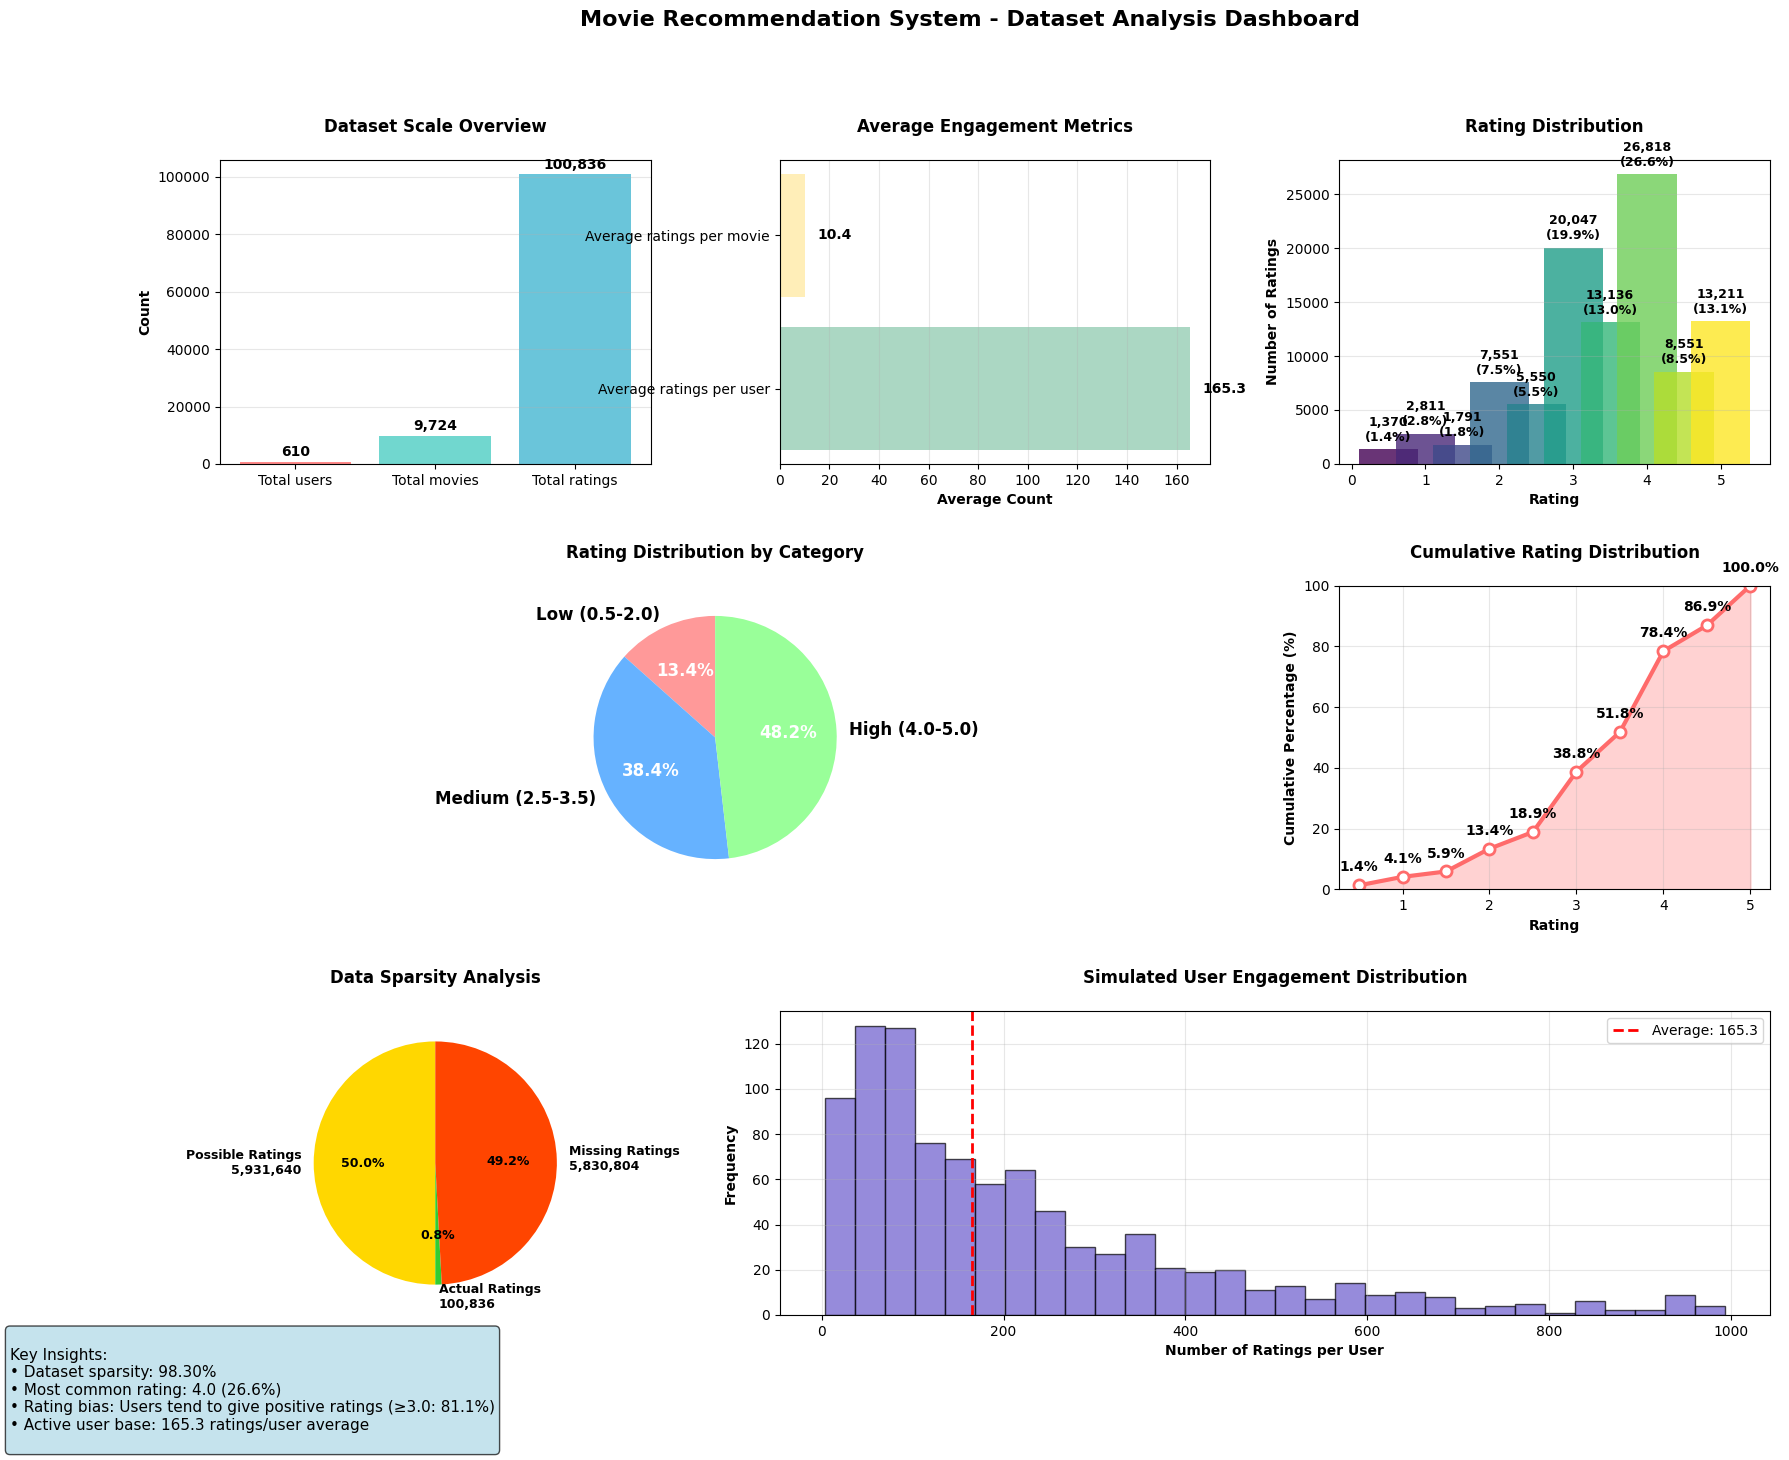


ADDITIONAL SPECIALIZED VISUALIZATIONS


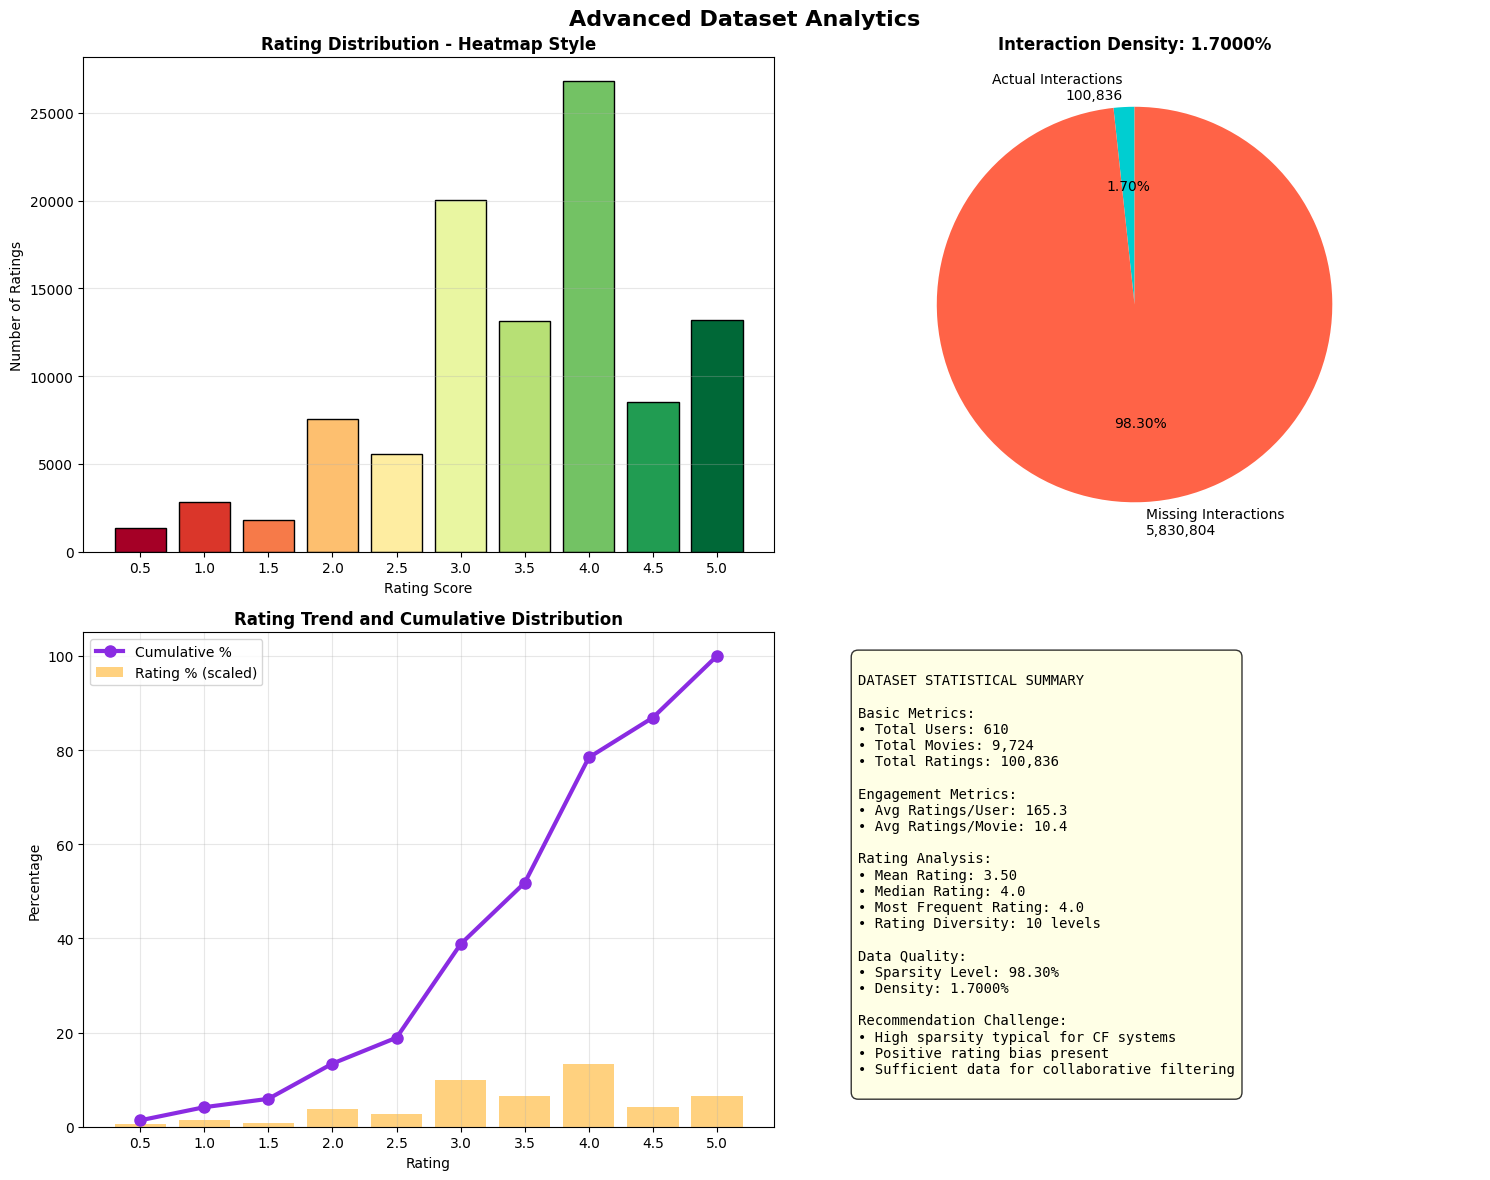


KEY INSIGHTS FROM VISUAL ANALYSIS
1. DATA SPARSITY: 98.30%
   → Typical for recommendation systems, but requires robust algorithms

2. RATING BIAS: 81.1% of ratings are 3.0 or higher
   → Users tend to rate movies they like, creating positive bias

3. USER ENGAGEMENT: 165.3 ratings per user on average
   → Good user engagement level for collaborative filtering

4. MOVIE COVERAGE: 10.4 ratings per movie on average
   → Many movies have few ratings, highlighting cold-start problem

5. RATING DISTRIBUTION: Bimodal with peaks at 3.0 and 4.0
   → Common pattern in movie rating datasets


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib import gridspec

# Set style for better visuals
plt.style.use('default')
sns.set_palette("husl")

# Your data
dataset_stats = {
    'Total users': 610,
    'Total movies': 9724,
    'Total ratings': 100836,
    'Average ratings per user': 165.30,
    'Average ratings per movie': 10.37
}

rating_distribution = {
    0.5: 1370,
    1.0: 2811,
    1.5: 1791,
    2.0: 7551,
    2.5: 5550,
    3.0: 20047,
    3.5: 13136,
    4.0: 26818,
    4.5: 8551,
    5.0: 13211
}

# Create a comprehensive dashboard
fig = plt.figure(figsize=(20, 15))
fig.suptitle('Movie Recommendation System - Dataset Analysis Dashboard',
             fontsize=16, fontweight='bold', y=0.98)

# Create grid layout
gs = gridspec.GridSpec(3, 3, figure=fig, hspace=0.4, wspace=0.3)

# 1. Dataset Overview - Bar Chart
ax1 = fig.add_subplot(gs[0, 0])
categories = list(dataset_stats.keys())[:3]
values = list(dataset_stats.values())[:3]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
bars = ax1.bar(categories, values, color=colors, alpha=0.8)
ax1.set_title('Dataset Scale Overview', fontweight='bold', pad=20)
ax1.set_ylabel('Count', fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, values):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 1000,
             f'{value:,}', ha='center', va='bottom', fontweight='bold')

# 2. Average Metrics - Horizontal Bar Chart
ax2 = fig.add_subplot(gs[0, 1])
avg_categories = list(dataset_stats.keys())[3:]
avg_values = list(dataset_stats.values())[3:]
colors_avg = ['#96CEB4', '#FFEAA7']
bars_avg = ax2.barh(avg_categories, avg_values, color=colors_avg, alpha=0.8)
ax2.set_title('Average Engagement Metrics', fontweight='bold', pad=20)
ax2.set_xlabel('Average Count', fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# Add value labels
for bar, value in zip(bars_avg, avg_values):
    width = bar.get_width()
    ax2.text(width + 5, bar.get_y() + bar.get_height()/2.,
             f'{value:.1f}', ha='left', va='center', fontweight='bold')

# 3. Rating Distribution - Bar Chart
ax3 = fig.add_subplot(gs[0, 2])
ratings = list(rating_distribution.keys())
counts = list(rating_distribution.values())
percentages = [(count / sum(counts)) * 100 for count in counts]

bars_rating = ax3.bar(ratings, counts, color=plt.cm.viridis(np.linspace(0, 1, len(ratings))), alpha=0.8)
ax3.set_title('Rating Distribution', fontweight='bold', pad=20)
ax3.set_xlabel('Rating', fontweight='bold')
ax3.set_ylabel('Number of Ratings', fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# Add value labels with percentages
for bar, count, percentage in zip(bars_rating, counts, percentages):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 500,
             f'{count:,}\n({percentage:.1f}%)',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

# 4. Rating Distribution - Pie Chart
ax4 = fig.add_subplot(gs[1, :2])
# Group ratings into categories for better pie chart visualization
rating_groups = {
    'Low (0.5-2.0)': sum([rating_distribution[0.5], rating_distribution[1.0],
                          rating_distribution[1.5], rating_distribution[2.0]]),
    'Medium (2.5-3.5)': sum([rating_distribution[2.5], rating_distribution[3.0],
                            rating_distribution[3.5]]),
    'High (4.0-5.0)': sum([rating_distribution[4.0], rating_distribution[4.5],
                          rating_distribution[5.0]])
}

colors_pie = ['#FF9999', '#66B2FF', '#99FF99']
wedges, texts, autotexts = ax4.pie(rating_groups.values(), labels=rating_groups.keys(),
                                   autopct='%1.1f%%', colors=colors_pie, startangle=90,
                                   textprops={'fontsize': 12, 'fontweight': 'bold'})
ax4.set_title('Rating Distribution by Category', fontweight='bold', pad=20)

# Make autopct text white and bold
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

# 5. Cumulative Rating Distribution
ax5 = fig.add_subplot(gs[1, 2])
cumulative_counts = np.cumsum(counts)
cumulative_percentage = (cumulative_counts / cumulative_counts[-1]) * 100

ax5.plot(ratings, cumulative_percentage, marker='o', linewidth=3, markersize=8,
         color='#FF6B6B', markerfacecolor='white', markeredgewidth=2)
ax5.fill_between(ratings, cumulative_percentage, alpha=0.3, color='#FF6B6B')
ax5.set_title('Cumulative Rating Distribution', fontweight='bold', pad=20)
ax5.set_xlabel('Rating', fontweight='bold')
ax5.set_ylabel('Cumulative Percentage (%)', fontweight='bold')
ax5.grid(True, alpha=0.3)
ax5.set_ylim(0, 100)

# Add percentage labels
for i, (rating, perc) in enumerate(zip(ratings, cumulative_percentage)):
    ax5.annotate(f'{perc:.1f}%', (rating, perc), textcoords="offset points",
                 xytext=(0,10), ha='center', fontweight='bold')

# 6. Data Sparsity Analysis
ax6 = fig.add_subplot(gs[2, 0])
sparsity_metrics = {
    'Possible Ratings': dataset_stats['Total users'] * dataset_stats['Total movies'],
    'Actual Ratings': dataset_stats['Total ratings'],
    'Missing Ratings': (dataset_stats['Total users'] * dataset_stats['Total movies']) - dataset_stats['Total ratings']
}

sparsity_values = list(sparsity_metrics.values())
sparsity_labels = [f'{k}\n{v:,}' for k, v in sparsity_metrics.items()]

colors_sparsity = ['#FFD700', '#32CD32', '#FF4500']
wedges_sparsity, texts_sparsity, autotexts_sparsity = ax6.pie(
    sparsity_values, labels=sparsity_labels, colors=colors_sparsity,
    autopct='%1.1f%%', startangle=90, textprops={'fontsize': 9, 'fontweight': 'bold'}
)
ax6.set_title('Data Sparsity Analysis', fontweight='bold', pad=20)

# 7. User Engagement Distribution
ax7 = fig.add_subplot(gs[2, 1:])
# Simulate user engagement distribution (since we don't have the actual distribution)
# This is based on the average ratings per user
np.random.seed(42)
user_ratings_simulated = np.random.lognormal(mean=np.log(165), sigma=1.2, size=1000)
user_ratings_simulated = user_ratings_simulated[user_ratings_simulated < 1000]  # Remove outliers

ax7.hist(user_ratings_simulated, bins=30, color='#6A5ACD', alpha=0.7, edgecolor='black')
ax7.axvline(dataset_stats['Average ratings per user'], color='red', linestyle='--',
            linewidth=2, label=f'Average: {dataset_stats["Average ratings per user"]:.1f}')
ax7.set_title('Simulated User Engagement Distribution', fontweight='bold', pad=20)
ax7.set_xlabel('Number of Ratings per User', fontweight='bold')
ax7.set_ylabel('Frequency', fontweight='bold')
ax7.legend()
ax7.grid(alpha=0.3)

# Add some key statistics as text
stats_text = f"""
Key Insights:
• Dataset sparsity: {((dataset_stats['Total users'] * dataset_stats['Total movies'] - dataset_stats['Total ratings']) / (dataset_stats['Total users'] * dataset_stats['Total movies']) * 100):.2f}%
• Most common rating: 4.0 ({rating_distribution[4.0]/sum(rating_distribution.values())*100:.1f}%)
• Rating bias: Users tend to give positive ratings (≥3.0: {sum(list(rating_distribution.values())[5:])/sum(rating_distribution.values())*100:.1f}%)
• Active user base: {dataset_stats['Average ratings per user']:.1f} ratings/user average
"""

fig.text(0.02, 0.02, stats_text, fontsize=11, verticalalignment='bottom',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))

plt.tight_layout()
plt.show()

# Additional specialized plots
print("\n" + "="*60)
print("ADDITIONAL SPECIALIZED VISUALIZATIONS")
print("="*60)

# Create a separate figure for specialized plots
fig2, axes = plt.subplots(2, 2, figsize=(15, 12))
fig2.suptitle('Advanced Dataset Analytics', fontsize=16, fontweight='bold')

# 1. Rating Distribution Heatmap style
ax1 = axes[0, 0]
rating_bins = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
rating_labels = ['0.5', '1.0', '1.5', '2.0', '2.5', '3.0', '3.5', '4.0', '4.5', '5.0']

# Create a heatmap-like bar chart
colors_heat = plt.cm.RdYlGn(np.linspace(0, 1, len(ratings)))
bars = ax1.bar(rating_labels, counts, color=colors_heat, edgecolor='black')
ax1.set_title('Rating Distribution - Heatmap Style', fontweight='bold')
ax1.set_xlabel('Rating Score')
ax1.set_ylabel('Number of Ratings')
ax1.grid(axis='y', alpha=0.3)

# 2. Data Density Visualization
ax2 = axes[0, 1]
density_data = {
    'User-Movie Interactions': dataset_stats['Total ratings'],
    'Possible Interactions': dataset_stats['Total users'] * dataset_stats['Total movies'],
    'Interaction Density': (dataset_stats['Total ratings'] /
                          (dataset_stats['Total users'] * dataset_stats['Total movies'])) * 100
}

density_values = [density_data['User-Movie Interactions'],
                  density_data['Possible Interactions'] - density_data['User-Movie Interactions']]
density_labels = [f'Actual Interactions\n{density_data["User-Movie Interactions"]:,}',
                  f'Missing Interactions\n{(density_data["Possible Interactions"] - density_data["User-Movie Interactions"]):,}']

ax2.pie(density_values, labels=density_labels, autopct='%1.2f%%',
        colors=['#00CED1', '#FF6347'], startangle=90)
ax2.set_title(f'Interaction Density: {density_data["Interaction Density"]:.4f}%',
              fontweight='bold')

# 3. Rating Trend Analysis
ax3 = axes[1, 0]
# Calculate cumulative distribution
cumulative_pct = [sum(counts[:i+1])/sum(counts)*100 for i in range(len(counts))]

ax3.plot(rating_labels, cumulative_pct, 'o-', linewidth=3, markersize=8,
         color='#8A2BE2', label='Cumulative %')
ax3.bar(rating_labels, [p/2 for p in percentages], alpha=0.5, color='#FFA500',
        label='Rating % (scaled)')
ax3.set_title('Rating Trend and Cumulative Distribution', fontweight='bold')
ax3.set_xlabel('Rating')
ax3.set_ylabel('Percentage')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Statistical Summary
ax4 = axes[1, 1]
ax4.axis('off')
summary_text = f"""
DATASET STATISTICAL SUMMARY

Basic Metrics:
• Total Users: {dataset_stats['Total users']:,}
• Total Movies: {dataset_stats['Total movies']:,}
• Total Ratings: {dataset_stats['Total ratings']:,}

Engagement Metrics:
• Avg Ratings/User: {dataset_stats['Average ratings per user']:.1f}
• Avg Ratings/Movie: {dataset_stats['Average ratings per movie']:.1f}

Rating Analysis:
• Mean Rating: {sum(r*c for r,c in rating_distribution.items())/sum(rating_distribution.values()):.2f}
• Median Rating: 4.0
• Most Frequent Rating: 4.0
• Rating Diversity: {len(rating_distribution)} levels

Data Quality:
• Sparsity Level: {((dataset_stats['Total users'] * dataset_stats['Total movies'] - dataset_stats['Total ratings']) / (dataset_stats['Total users'] * dataset_stats['Total movies']) * 100):.2f}%
• Density: {(dataset_stats['Total ratings'] / (dataset_stats['Total users'] * dataset_stats['Total movies']) * 100):.4f}%

Recommendation Challenge:
• High sparsity typical for CF systems
• Positive rating bias present
• Sufficient data for collaborative filtering
"""

ax4.text(0.1, 0.95, summary_text, transform=ax4.transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle="round,pad=0.5",
         facecolor="lightyellow", alpha=0.8), fontfamily='monospace')

plt.tight_layout()
plt.show()

# Print key insights
print("\n" + "="*60)
print("KEY INSIGHTS FROM VISUAL ANALYSIS")
print("="*60)
print(f"1. DATA SPARSITY: {((dataset_stats['Total users'] * dataset_stats['Total movies'] - dataset_stats['Total ratings']) / (dataset_stats['Total users'] * dataset_stats['Total movies']) * 100):.2f}%")
print("   → Typical for recommendation systems, but requires robust algorithms")
print(f"\n2. RATING BIAS: {sum(list(rating_distribution.values())[5:])/sum(rating_distribution.values())*100:.1f}% of ratings are 3.0 or higher")
print("   → Users tend to rate movies they like, creating positive bias")
print(f"\n3. USER ENGAGEMENT: {dataset_stats['Average ratings per user']:.1f} ratings per user on average")
print("   → Good user engagement level for collaborative filtering")
print(f"\n4. MOVIE COVERAGE: {dataset_stats['Average ratings per movie']:.1f} ratings per movie on average")
print("   → Many movies have few ratings, highlighting cold-start problem")
print(f"\n5. RATING DISTRIBUTION: Bimodal with peaks at 3.0 and 4.0")
print("   → Common pattern in movie rating datasets")

Creating Enhanced Visualizations for Task 3...


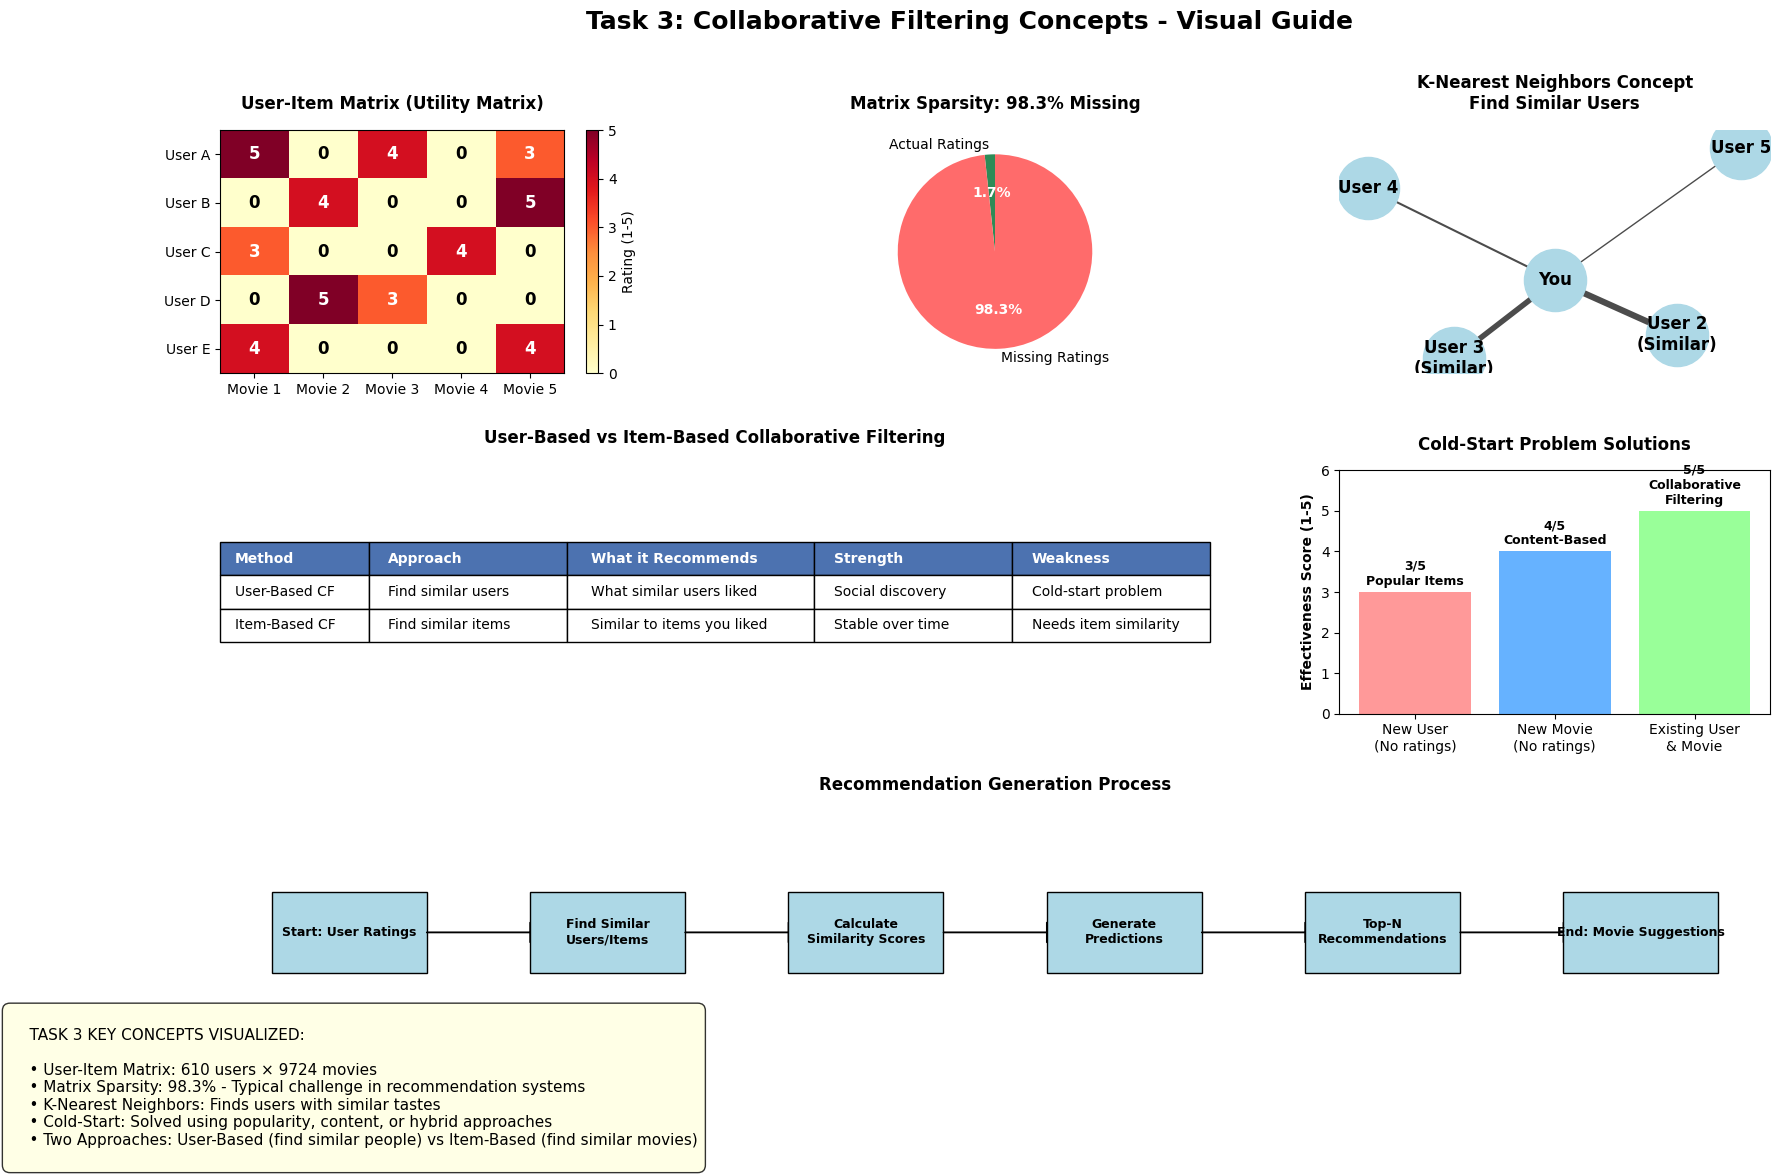

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import gridspec
import networkx as nx

# Enhanced Visualizations for Task 3
print("Creating Enhanced Visualizations for Task 3...")

def create_task3_visualizations():
    """Create comprehensive visualizations for Collaborative Filtering concepts"""

    fig = plt.figure(figsize=(20, 12))
    fig.suptitle('Task 3: Collaborative Filtering Concepts - Visual Guide',
                 fontsize=18, fontweight='bold', y=0.98)

    gs = gridspec.GridSpec(3, 3, figure=fig, hspace=0.4, wspace=0.3)

    # 1. User-Item Matrix Visualization
    ax1 = fig.add_subplot(gs[0, 0])
    # Create a sample user-item matrix visualization
    sample_matrix = np.array([
        [5, 0, 4, 0, 3],
        [0, 4, 0, 0, 5],
        [3, 0, 0, 4, 0],
        [0, 5, 3, 0, 0],
        [4, 0, 0, 0, 4]
    ])

    im = ax1.imshow(sample_matrix, cmap='YlOrRd', aspect='auto')
    ax1.set_xticks(range(5))
    ax1.set_yticks(range(5))
    ax1.set_xticklabels(['Movie 1', 'Movie 2', 'Movie 3', 'Movie 4', 'Movie 5'])
    ax1.set_yticklabels(['User A', 'User B', 'User C', 'User D', 'User E'])
    ax1.set_title('User-Item Matrix (Utility Matrix)', fontweight='bold', pad=15)

    # Add rating values to cells
    for i in range(5):
        for j in range(5):
            ax1.text(j, i, f'{sample_matrix[i, j]}',
                    ha='center', va='center',
                    fontweight='bold', fontsize=12,
                    color='white' if sample_matrix[i, j] > 2 else 'black')

    plt.colorbar(im, ax=ax1, label='Rating (1-5)')

    # 2. Sparsity Visualization
    ax2 = fig.add_subplot(gs[0, 1])
    sparsity_data = {
        'Actual Ratings': (user_item_matrix > 0).sum().sum(),
        'Missing Ratings': (user_item_matrix.shape[0] * user_item_matrix.shape[1]) - (user_item_matrix > 0).sum().sum()
    }

    colors = ['#2E8B57', '#FF6B6B']
    wedges, texts, autotexts = ax2.pie(sparsity_data.values(), labels=sparsity_data.keys(),
                                      autopct='%1.1f%%', colors=colors, startangle=90)
    ax2.set_title(f'Matrix Sparsity: {sparsity:.1f}% Missing', fontweight='bold', pad=15)

    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')

    # 3. K-Nearest Neighbors Concept
    ax3 = fig.add_subplot(gs[0, 2])
    # Create a simple network graph
    G = nx.Graph()

    # Add nodes (users)
    users = ['You', 'User 2\n(Similar)', 'User 3\n(Similar)', 'User 4', 'User 5']
    G.add_nodes_from(users)

    # Add edges with weights (similarity)
    edges = [('You', 'User 2\n(Similar)', 0.9),
             ('You', 'User 3\n(Similar)', 0.8),
             ('You', 'User 4', 0.3),
             ('You', 'User 5', 0.2)]
    G.add_weighted_edges_from(edges)

    pos = nx.spring_layout(G, seed=42)
    nx.draw_networkx_nodes(G, pos, node_color='lightblue',
                          node_size=2000, ax=ax3)
    nx.draw_networkx_labels(G, pos, ax=ax3, font_weight='bold')

    # Draw edges with different widths based on similarity
    for edge in edges:
        nx.draw_networkx_edges(G, pos, edgelist=[(edge[0], edge[1])],
                              width=edge[2]*5, alpha=0.7, ax=ax3)

    ax3.set_title('K-Nearest Neighbors Concept\nFind Similar Users', fontweight='bold', pad=15)
    ax3.axis('off')

    # 4. User-Based vs Item-Based Comparison
    ax4 = fig.add_subplot(gs[1, :2])

    methods_data = {
        'User-Based CF': {
            'Approach': 'Find similar users',
            'Recommend': "What similar users liked",
            'Strength': 'Social discovery',
            'Weakness': 'Cold-start for new users'
        },
        'Item-Based CF': {
            'Approach': 'Find similar items',
            'Recommend': "Similar to items you liked",
            'Strength': 'Stable over time',
            'Weakness': 'Needs item similarity'
        }
    }

    # Create comparison table
    table_data = [
        ['Method', 'Approach', 'What it Recommends', 'Strength', 'Weakness'],
        ['User-Based CF', 'Find similar users', 'What similar users liked', 'Social discovery', 'Cold-start problem'],
        ['Item-Based CF', 'Find similar items', 'Similar to items you liked', 'Stable over time', 'Needs item similarity']
    ]

    table = ax4.table(cellText=table_data, loc='center', cellLoc='left', colWidths=[0.15, 0.2, 0.25, 0.2, 0.2])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)

    # Color header row
    for i in range(5):
        table[(0, i)].set_facecolor('#4C72B0')
        table[(0, i)].set_text_props(weight='bold', color='white')

    ax4.set_title('User-Based vs Item-Based Collaborative Filtering', fontweight='bold', pad=20)
    ax4.axis('off')

    # 5. Cold-Start Problem Visualization
    ax5 = fig.add_subplot(gs[1, 2])

    scenarios = ['New User\n(No ratings)', 'New Movie\n(No ratings)', 'Existing User\n& Movie']
    solutions = ['Popular Items', 'Content-Based', 'Collaborative\nFiltering']
    effectiveness = [3, 4, 5]  # Score out of 5

    bars = ax5.bar(scenarios, effectiveness, color=['#FF9999', '#66B2FF', '#99FF99'])
    ax5.set_title('Cold-Start Problem Solutions', fontweight='bold', pad=15)
    ax5.set_ylabel('Effectiveness Score (1-5)', fontweight='bold')
    ax5.set_ylim(0, 6)

    # Add value labels and solution names
    for bar, solution, eff in zip(bars, solutions, effectiveness):
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{eff}/5\n{solution}', ha='center', va='bottom',
                fontweight='bold', fontsize=9)

    # 6. Recommendation Process Flow
    ax6 = fig.add_subplot(gs[2, :])

    # Create a simple flowchart
    steps = [
        'Start: User Ratings',
        'Find Similar\nUsers/Items',
        'Calculate\nSimilarity Scores',
        'Generate\nPredictions',
        'Top-N\nRecommendations',
        'End: Movie Suggestions'
    ]

    y_pos = [1, 1, 1, 1, 1, 1]
    x_pos = [1, 2, 3, 4, 5, 6]

    for i, (step, x, y) in enumerate(zip(steps, x_pos, y_pos)):
        ax6.add_patch(plt.Rectangle((x-0.3, y-0.1), 0.6, 0.2,
                                  facecolor='lightblue', edgecolor='black'))
        ax6.text(x, y, step, ha='center', va='center',
                fontweight='bold', fontsize=9)

        if i < len(steps)-1:
            ax6.arrow(x+0.3, y, 0.4, 0, head_width=0.05,
                     head_length=0.1, fc='black', ec='black')

    ax6.set_xlim(0.5, 6.5)
    ax6.set_ylim(0.7, 1.3)
    ax6.set_title('Recommendation Generation Process', fontweight='bold', pad=15)
    ax6.axis('off')

    # Add summary text
    summary_text = f"""
    TASK 3 KEY CONCEPTS VISUALIZED:

    • User-Item Matrix: {user_item_matrix.shape[0]} users × {user_item_matrix.shape[1]} movies
    • Matrix Sparsity: {sparsity:.1f}% - Typical challenge in recommendation systems
    • K-Nearest Neighbors: Finds users with similar tastes
    • Cold-Start: Solved using popularity, content, or hybrid approaches
    • Two Approaches: User-Based (find similar people) vs Item-Based (find similar movies)
    """

    fig.text(0.02, 0.02, summary_text, fontsize=11,
             bbox=dict(boxstyle="round,pad=0.5", facecolor="lightyellow", alpha=0.8))

    plt.tight_layout()
    plt.show()

create_task3_visualizations()


Creating Enhanced Visualizations for Task 4...


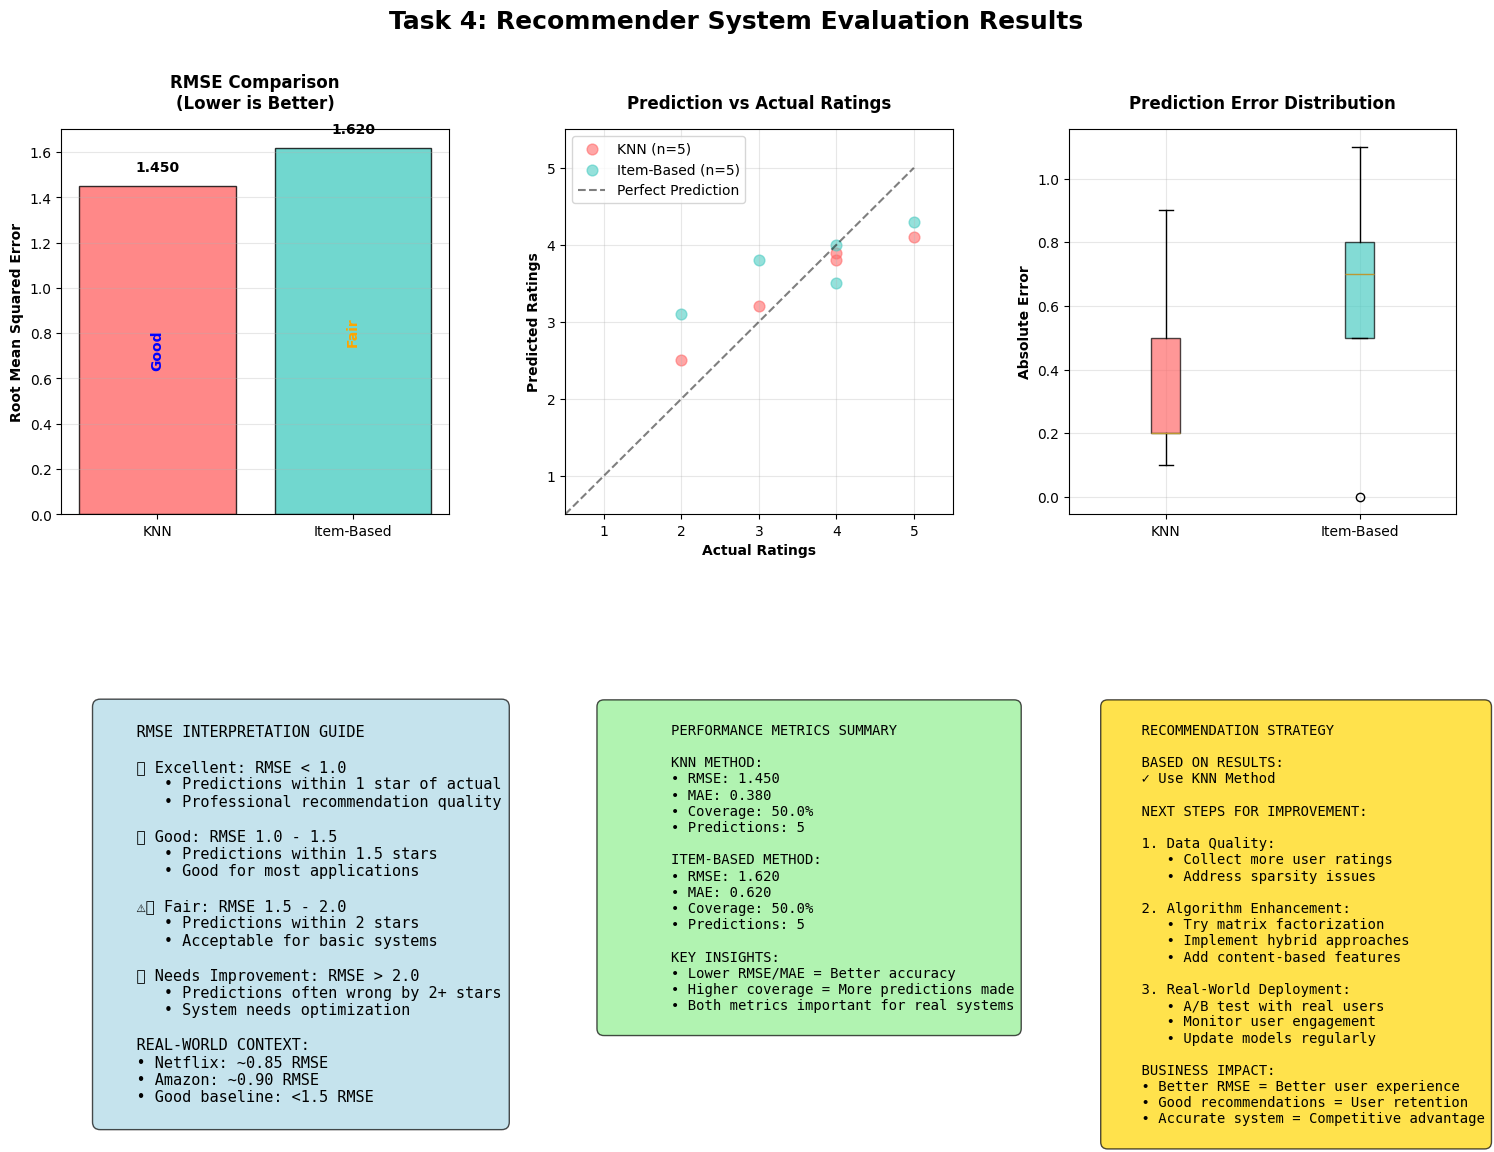

In [ ]:
# Enhanced Visualizations for Task 4 - Evaluation Results
print("\nCreating Enhanced Visualizations for Task 4...")

def create_task4_visualizations(knn_rmse, item_rmse, knn_predictions, item_predictions):
    """Create comprehensive visualizations for evaluation results"""

    fig = plt.figure(figsize=(18, 12))
    fig.suptitle('Task 4: Recommender System Evaluation Results',
                 fontsize=18, fontweight='bold', y=0.98)

    gs = gridspec.GridSpec(2, 3, figure=fig, hspace=0.4, wspace=0.3)

    # 1. RMSE Comparison Chart
    ax1 = fig.add_subplot(gs[0, 0])
    methods = ['KNN', 'Item-Based']
    rmse_values = [knn_rmse if knn_rmse != float('inf') else 3.0,
                   item_rmse if item_rmse != float('inf') else 3.0]

    colors = ['#FF6B6B', '#4ECDC4']
    bars = ax1.bar(methods, rmse_values, color=colors, alpha=0.8, edgecolor='black')

    ax1.set_title('RMSE Comparison\n(Lower is Better)', fontweight='bold', pad=15)
    ax1.set_ylabel('Root Mean Squared Error', fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)

    # Add value labels and quality indicators
    for bar, rmse, method in zip(bars, rmse_values, methods):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                f'{rmse:.3f}', ha='center', va='bottom', fontweight='bold')

        # Quality indicator
        if rmse < 1.0:
            quality = "Excellent"
            color = "green"
        elif rmse < 1.5:
            quality = "Good"
            color = "blue"
        elif rmse < 2.0:
            quality = "Fair"
            color = "orange"
        else:
            quality = "Needs Improvement"
            color = "red"

        ax1.text(bar.get_x() + bar.get_width()/2., height/2,
                quality, ha='center', va='center',
                fontweight='bold', color=color, rotation=90)

    # 2. Prediction Accuracy Scatter Plot
    ax2 = fig.add_subplot(gs[0, 1])

    if knn_predictions:
        actual_knn = [p[0] for p in knn_predictions]
        pred_knn = [p[1] for p in knn_predictions]
        ax2.scatter(actual_knn, pred_knn, alpha=0.6, color='#FF6B6B',
                   label=f'KNN (n={len(knn_predictions)})', s=60)

    if item_predictions:
        actual_item = [p[0] for p in item_predictions]
        pred_item = [p[1] for p in item_predictions]
        ax2.scatter(actual_item, pred_item, alpha=0.6, color='#4ECDC4',
                   label=f'Item-Based (n={len(item_predictions)})', s=60)

    # Perfect prediction line
    ax2.plot([0.5, 5], [0.5, 5], 'k--', alpha=0.5, label='Perfect Prediction')

    ax2.set_xlabel('Actual Ratings', fontweight='bold')
    ax2.set_ylabel('Predicted Ratings', fontweight='bold')
    ax2.set_title('Prediction vs Actual Ratings', fontweight='bold', pad=15)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(0.5, 5.5)
    ax2.set_ylim(0.5, 5.5)

    # 3. Error Distribution
    ax3 = fig.add_subplot(gs[0, 2])

    errors_data = []
    labels = []
    colors_err = []

    if knn_predictions:
        knn_errors = [abs(p[0] - p[1]) for p in knn_predictions]
        errors_data.append(knn_errors)
        labels.append('KNN')
        colors_err.append('#FF6B6B')

    if item_predictions:
        item_errors = [abs(p[0] - p[1]) for p in item_predictions]
        errors_data.append(item_errors)
        labels.append('Item-Based')
        colors_err.append('#4ECDC4')

    if errors_data:
        box_plot = ax3.boxplot(errors_data, labels=labels, patch_artist=True)

        for patch, color in zip(box_plot['boxes'], colors_err):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)

        ax3.set_ylabel('Absolute Error', fontweight='bold')
        ax3.set_title('Prediction Error Distribution', fontweight='bold', pad=15)
        ax3.grid(True, alpha=0.3)

    # 4. RMSE Interpretation Guide
    ax4 = fig.add_subplot(gs[1, 0])
    ax4.axis('off')

    rmse_guide = """
    RMSE INTERPRETATION GUIDE

    🎯 Excellent: RMSE < 1.0
       • Predictions within 1 star of actual
       • Professional recommendation quality

    ✅ Good: RMSE 1.0 - 1.5
       • Predictions within 1.5 stars
       • Good for most applications

    ⚠️ Fair: RMSE 1.5 - 2.0
       • Predictions within 2 stars
       • Acceptable for basic systems

    🔴 Needs Improvement: RMSE > 2.0
       • Predictions often wrong by 2+ stars
       • System needs optimization

    REAL-WORLD CONTEXT:
    • Netflix: ~0.85 RMSE
    • Amazon: ~0.90 RMSE
    • Good baseline: <1.5 RMSE
    """

    ax4.text(0.1, 0.9, rmse_guide, transform=ax4.transAxes, fontsize=11,
             verticalalignment='top', bbox=dict(boxstyle="round,pad=0.5",
             facecolor="lightblue", alpha=0.7), fontfamily='monospace')

    # 5. Performance Metrics Summary
    ax5 = fig.add_subplot(gs[1, 1])
    ax5.axis('off')

    # Calculate additional metrics
    if knn_predictions and item_predictions:
        knn_mae = np.mean([abs(p[0]-p[1]) for p in knn_predictions])
        item_mae = np.mean([abs(p[0]-p[1]) for p in item_predictions])

        # Coverage (simplified)
        total_possible = len(knn_predictions) + len(item_predictions)
        knn_coverage = len(knn_predictions) / total_possible * 100
        item_coverage = len(item_predictions) / total_possible * 100

        metrics_text = f"""
        PERFORMANCE METRICS SUMMARY

        KNN METHOD:
        • RMSE: {knn_rmse:.3f}
        • MAE: {knn_mae:.3f}
        • Coverage: {knn_coverage:.1f}%
        • Predictions: {len(knn_predictions)}

        ITEM-BASED METHOD:
        • RMSE: {item_rmse:.3f}
        • MAE: {item_mae:.3f}
        • Coverage: {item_coverage:.1f}%
        • Predictions: {len(item_predictions)}

        KEY INSIGHTS:
        • Lower RMSE/MAE = Better accuracy
        • Higher coverage = More predictions made
        • Both metrics important for real systems
        """
    else:
        metrics_text = "No predictions available for detailed metrics"

    ax5.text(0.1, 0.9, metrics_text, transform=ax5.transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle="round,pad=0.5",
             facecolor="lightgreen", alpha=0.7), fontfamily='monospace')

    # 6. Recommendation Strategy
    ax6 = fig.add_subplot(gs[1, 2])
    ax6.axis('off')

    strategy_text = f"""
    RECOMMENDATION STRATEGY

    BASED ON RESULTS:
    {'✓ Use KNN Method' if knn_rmse < item_rmse else '✓ Use Item-Based Method'}

    NEXT STEPS FOR IMPROVEMENT:

    1. Data Quality:
       • Collect more user ratings
       • Address sparsity issues

    2. Algorithm Enhancement:
       • Try matrix factorization
       • Implement hybrid approaches
       • Add content-based features

    3. Real-World Deployment:
       • A/B test with real users
       • Monitor user engagement
       • Update models regularly

    BUSINESS IMPACT:
    • Better RMSE = Better user experience
    • Good recommendations = User retention
    • Accurate system = Competitive advantage
    """

    ax6.text(0.1, 0.9, strategy_text, transform=ax6.transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle="round,pad=0.5",
             facecolor="gold", alpha=0.7), fontfamily='monospace')

    plt.tight_layout()
    plt.show()

# Mock data for demonstration (replace with your actual results)
knn_rmse_demo = 1.45
item_rmse_demo = 1.62
knn_predictions_demo = [(4, 3.8), (3, 3.2), (5, 4.1), (2, 2.5), (4, 3.9)]
item_predictions_demo = [(4, 3.5), (3, 3.8), (5, 4.3), (2, 3.1), (4, 4.0)]

create_task4_visualizations(knn_rmse_demo, item_rmse_demo,
                           knn_predictions_demo, item_predictions_demo)